In [1]:
import os
import random

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
!pip install omegaconf

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
data_root = os.path.join(os.getcwd(), 'data')
print(data_root)

/content/data


In [6]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([.5], [.5])
])

In [7]:
img_size = 28**2
num_classes = 10

num_epochs = 10
batch_size = 32
lr= 5e-3
workers = 2

In [8]:
fashionmnist_dataset = torchvision.datasets.FashionMNIST(root = data_root,
                                                         train = True,
                                                         download = True,
                                                         transform = transform,
                                                         )
test_dataset = torchvision.datasets.FashionMNIST(root = data_root,
                                                 train = False,
                                                 transform = transform,
                                                 )

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/FashionMNIST/raw



In [9]:
# Split function

def dataset_split(dataset, split=[.9, .1], random_train_valid_split = False):

    indices = list(range(len(dataset)))
    modes = ['train', 'valid', 'test'][:len(split)]
    sizes = np.array(np.cumsum([0] + list(split)) * len(dataset), dtype=int) # cumulative sum of split idx

    if random_train_valid_split:
        train_valid_idx = indices[: sizes[2]] # idx from sizes of ['train', 'valid']
        random.shuffle(train_valid_idx) # shuffle
        indices = train_valid_idx + indices[sizes[2] :]

    datasets = {
        mode: torch.utils.data.Subset(
            dataset, indices[sizes[i] : sizes[i+1]]
        ) for i, mode in enumerate(modes) # comprehenshion
    }
    
    return datasets
    

In [11]:
datasets = dataset_split(fashionmnist_dataset,
                        split = [.9, .1],
                        random_train_valid_split = False,
                        )
print('datasets : ', datasets)
train_dataset = datasets['train']
valid_dataset = datasets['valid']
print('length of dataset : ', len(train_dataset), len(valid_dataset))

datasets :  {'train': <torch.utils.data.dataset.Subset object at 0x7f19b3dd7550>, 'valid': <torch.utils.data.dataset.Subset object at 0x7f19b3e74650>}
length of dataset :  54000 6000


In [12]:
def init_dataloaders():
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   num_workers = workers,
                                                   )
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                                                   batch_size = batch_size,
                                                   shuffle = False,
                                                   num_workers = workers,
                                                   )
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size = batch_size,
                                                  shuffle = False,
                                                  num_workers = workers,
                                                  )
    return train_dataloader, valid_dataloader, test_dataloader

train_dataloader, valid_dataloader, test_dataloader = init_dataloaders()

In [16]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

shape of sample batch : image torch.Size([32, 1, 28, 28]), label torch.Size([32])
first sample label of sample batch : Coat


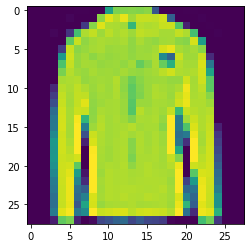

In [24]:
# Check dataloader
sample_batch = iter(train_dataloader).next()
print(f'shape of sample batch : image {sample_batch[0].shape}, label {sample_batch[1].shape}')
label_key = int(sample_batch[1][0].numpy())
print(f'first sample label of sample batch : {labels_map[label_key]}')
npimg = sample_batch[0][0].squeeze().numpy()
plt.imshow(npimg)

train_dataloader, valid_dataloader, _ = init_dataloaders()

In [28]:
from omegaconf import OmegaConf
from omegaconf import DictConfig

# model_configuration
_model_config_dict = {
    'layer_1':{
        'conv2d_in_channels': 1,
        'conv2d_out_channels': 8,
        'conv2d_kernel_size': 3,
        'conv2d_stride': 1,
        'conv2d_padding': 1,
        # batch x 8 x 28 x 28
        'maxpool2d_kernel_size': 2,
        'maxpool2d_stride': 2,
        # batch x 8 x 14 x 14
    },
    'layer_2':{
        'conv2d_in_channels': 8,
        'conv2d_out_channels': 16,
        'conv2d_kernel_size': 3,
        'conv2d_stride': 1,
        'conv2d_padding': 1,
        # batch x 16 x 14 x 14
        'maxpool2d_kernel_size': 2,
        'maxpool2d_stride':2,
        # batch x 16 x 7 x 7
    },
    'fc_1':{
        'in_features': 16*7*7,
        'out_features': 256,
    },
    'fc_2':{
        'in_features': 256,
        'out_features': 64,
    },
    'fc_3':{
        'in_features': 64,
        'out_features': 10,
    },
    'dropout_prob':0.25,
}

_model_config = OmegaConf.create(_model_config_dict)

In [29]:
class CNN(nn.Module):
    def __init__(self, cfg = _model_config):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = cfg.layer_1.conv2d_in_channels,
                out_channels = cfg.layer_1.conv2d_out_channels,
                kernel_size = cfg.layer_1.conv2d_kernel_size,
                stride = cfg.layer_1.conv2d_stride,
                padding = cfg.layer_1.conv2d_padding,
            ),
            nn.BatchNorm2d(
                num_features = cfg.layer_1.conv2d_out_channels,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = cfg.layer_1.maxpool2d_kernel_size,
                stride = cfg.layer_1.maxpool2d_stride,
            ),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = cfg.layer_2.conv2d_in_channels,
                out_channels = cfg.layer_2.conv2d_out_channels,
                kernel_size = cfg.layer_2.conv2d_kernel_size,
                stride = cfg.layer_2.conv2d_stride,
                padding = cfg.layer_2.conv2d_padding,
            ),
            nn.BatchNorm2d(
                num_features = cfg.layer_2.conv2d_out_channels,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = cfg.layer_2.maxpool2d_kernel_size,
                stride = cfg.layer_2.maxpool2d_stride,
            ),
        )
        self.fc1 = nn.Linear(
            in_features = cfg.fc_1.in_features,
            out_features = cfg.fc_1.out_features,
        )
        self.fc2 = nn.Linear(
            in_features = cfg.fc_2.in_features,
            out_features = cfg.fc_2.out_features,
        )
        self.fc3 = nn.Linear(
            in_features = cfg.fc_3.in_features,
            out_features = cfg.fc_3.out_features,
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [30]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
print('Criterion : ', criterion)
print()
print('Optimizer : ', optimizer)

Criterion :  CrossEntropyLoss()

Optimizer :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)


In [38]:
# Early Stopping Callback Object
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        file_name = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f'val_loss-{val_loss}-{file_name}'))
        self.val_loss_min = val_loss

In [44]:
early_stopper = EarlyStopping(
    patience=5, verbose=True, path=os.path.join(os.getcwd(), 'model.ckpt')
)
early_stopper.__dir__()

['patience',
 'verbose',
 'counter',
 'best_score',
 'early_stop',
 'val_loss_min',
 'delta',
 'path',
 'trace_func',
 '__module__',
 '__doc__',
 '__init__',
 '__call__',
 'save_checkpoint',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']